# Demonstration of risky choice tasks

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
import pandas as pd
import numpy as np

import darc
from darc.risky import models
from darc.designs import BayesianAdaptiveDesignGeneratorDARC, DesignSpaceBuilder
from darc.risky.designs import Griskevicius2011, DuGreenMyerson2002
from dev.darc_parameter_recovery import parameter_recovery_sweep, simulated_experiment_trial_loop
from darc.data_plotting import data_plotter

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data generating process
Define everything related to the true simulated observer which generates the data

In [4]:
data_generating_model = models.LinearInLogOdds

probs = np.linspace(0, 1, 100)

def linear_log_odds_weighting_function(p, δ, γ):
    return (δ*p**γ) / ((δ*p**γ) + (1-p)**γ)

def posterior_predictive(ax, fitted_model):
    # get posterior samples
    δ = fitted_model.θ['δ'].values
    γ = fitted_model.θ['γ'].values
    δ_percentiles = np.percentile(δ,[2.5, 50, 100-2.5])
    γ_percentiles = np.percentile(δ,[2.5, 50, 100-2.5])
    
    # y_upper = linear_log_odds_weighting_function(probs, logh_percentiles[2])
    y_median = linear_log_odds_weighting_function(probs, δ_percentiles[1], γ_percentiles[1])
    # y_lower = linear_log_odds_weighting_function(probs, logh_percentiles[0])

    # ax.fill_between(probs, y_lower, y_upper, alpha=0.3, label='95% CI')
    ax.plot(probs, y_median, label='posterior median')
    ax.legend()

true_params = [pd.DataFrame.from_dict({'δ': [0.2], 'γ': [0.2], 'α': [2]}),
               pd.DataFrame.from_dict({'δ': [0.6], 'γ': [1.0], 'α': [2]}),
               pd.DataFrame.from_dict({'δ': [1.8], 'γ': [1.8], 'α': [2]})]

col_titles = ['XXX', 'YYY', 'ZZZ']

In [5]:
true_params[0]

,δ,γ,α
0,0.2,0.2,2


## Code for visualising the various design approaches


Run simulated experiments

In [6]:
prob_list = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95]

D = DesignSpaceBuilder(DA=[0], 
                       DB=[0], 
                       PA=[1], 
                       PB=prob_list,
                       RA=list(100*np.linspace(0.05, 0.95, 91)),
                       RB=[100]).build()

BAD = lambda: BayesianAdaptiveDesignGeneratorDARC(D, max_trials=20)

design_types = [Griskevicius2011, 
                DuGreenMyerson2002,
                BAD]

row_headings = ['Griskevicius\n et al (2011)',
                'Du, Green & Myerson\n(2002)',
                'our approach']

row, col = (0,0)
row, col = (1,0)
row, col = (2,0)


/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:153: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled+n_times_sampled_iter))
/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:226: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled + n_times_sampled_iter))


row, col = (0,1)
row, col = (1,1)
row, col = (2,1)
row, col = (0,2)
row, col = (1,2)
row, col = (2,2)


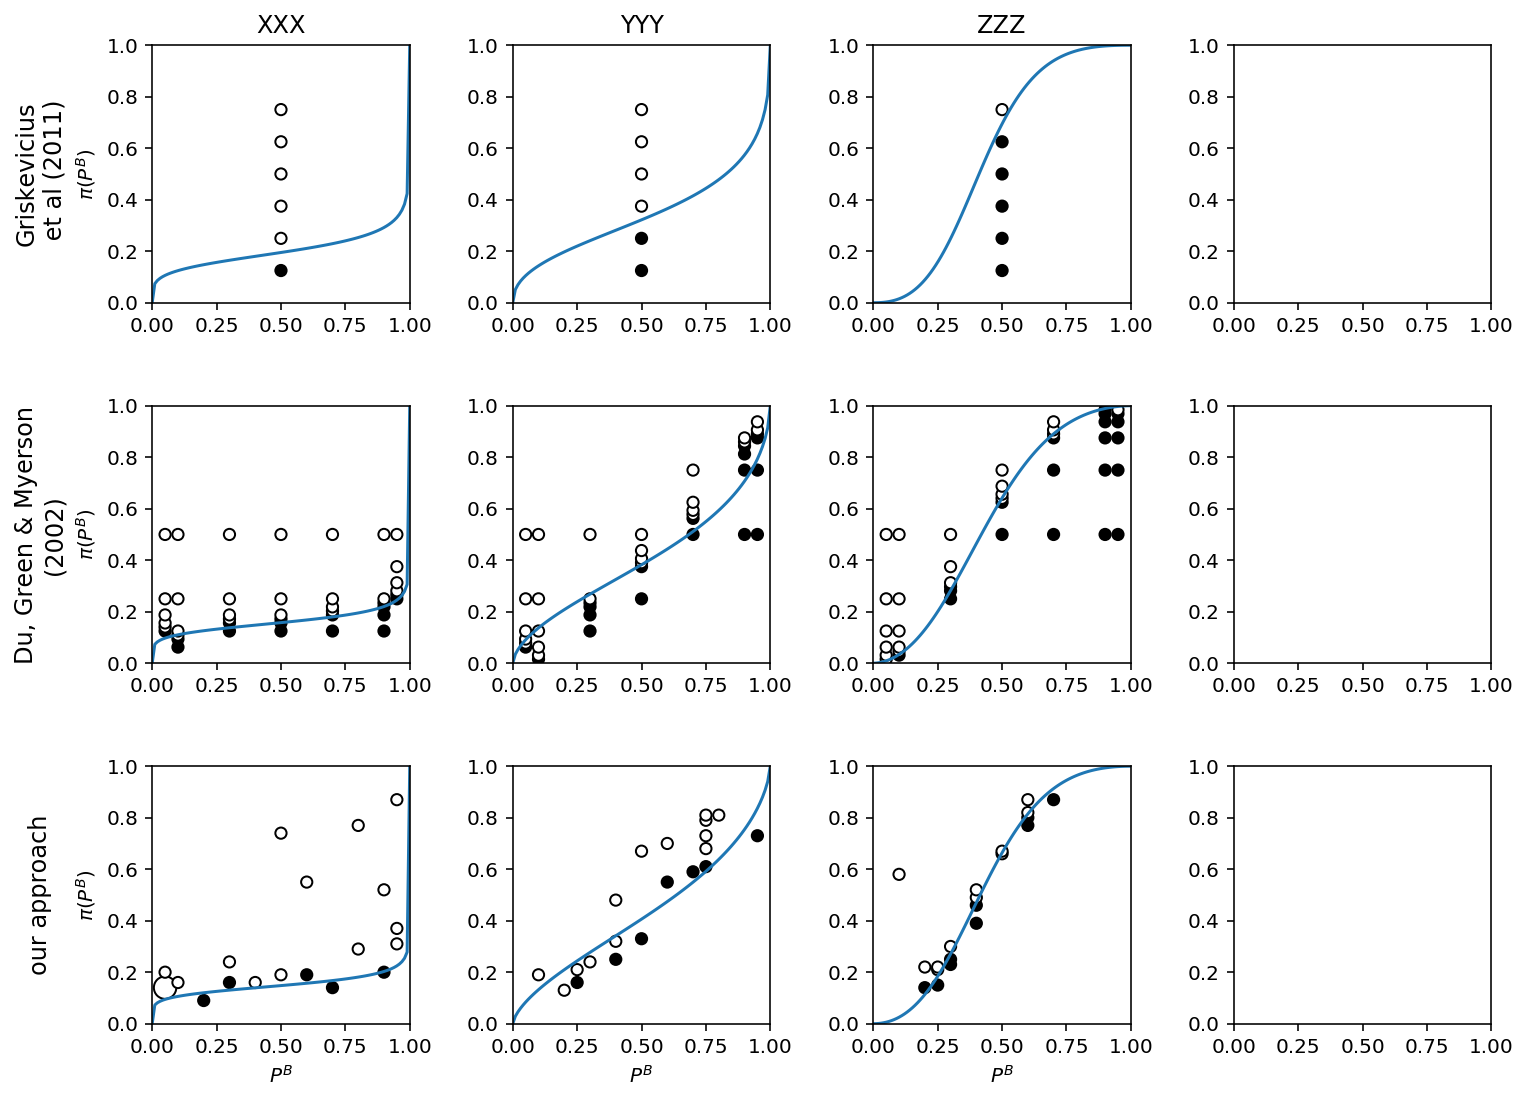

In [7]:
fig, ax = plt.subplots(len(design_types), len(true_params)+1, figsize=(12, 9))

for col, true_p in enumerate(true_params):
    for row, designfunc in enumerate(design_types):
        print(f'row, col = ({row},{col})')
        design_thing = designfunc()
        model = data_generating_model(n_particles=5000)
        model.θ_true = true_p  # pd.DataFrame.from_dict(true_p)
        fitted_model, _ = simulated_experiment_trial_loop(design_thing,
                                                          model,
                                                          track_this_parameter=None)
        data_plotter(design_thing.get_df(), ax=ax[row,col])
        posterior_predictive(ax[row,col], fitted_model)
        
#         # plot true
#         y_true = linear_log_odds_weighting_function(probs, 
#                                                     true_params[col]['δ'].values[0], 
#                                                     true_params[col]['γ'].values[0])
#         ax[row,col].plot(probs, y_true, col='k', label='true')
        
        if col > 0:
            ax[row,col].set_ylabel('')
        
        if row < len(design_types)-1:
            ax[row,col].set_xlabel('')

plt.subplots_adjust(hspace=0.4, wspace=0.4)

[ax[r,c].set_xlim([0, 1]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[r,c].set_ylim([0, 1]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[0,c].set_title(title) for c, title in enumerate(col_titles)]
[ax[r,c].get_legend().remove() for r in range(len(design_types)) for c in range(len(true_params))]

pad = 13 # in points
for axis, row_title in zip(ax[:,0], row_headings):
    axis.annotate(row_title, xy=(0, 0.5), xytext=(-axis.yaxis.labelpad - pad, 0),
                  xycoords=axis.yaxis.label, textcoords='offset points',
                  size='large', ha='center', va='center', rotation=90)


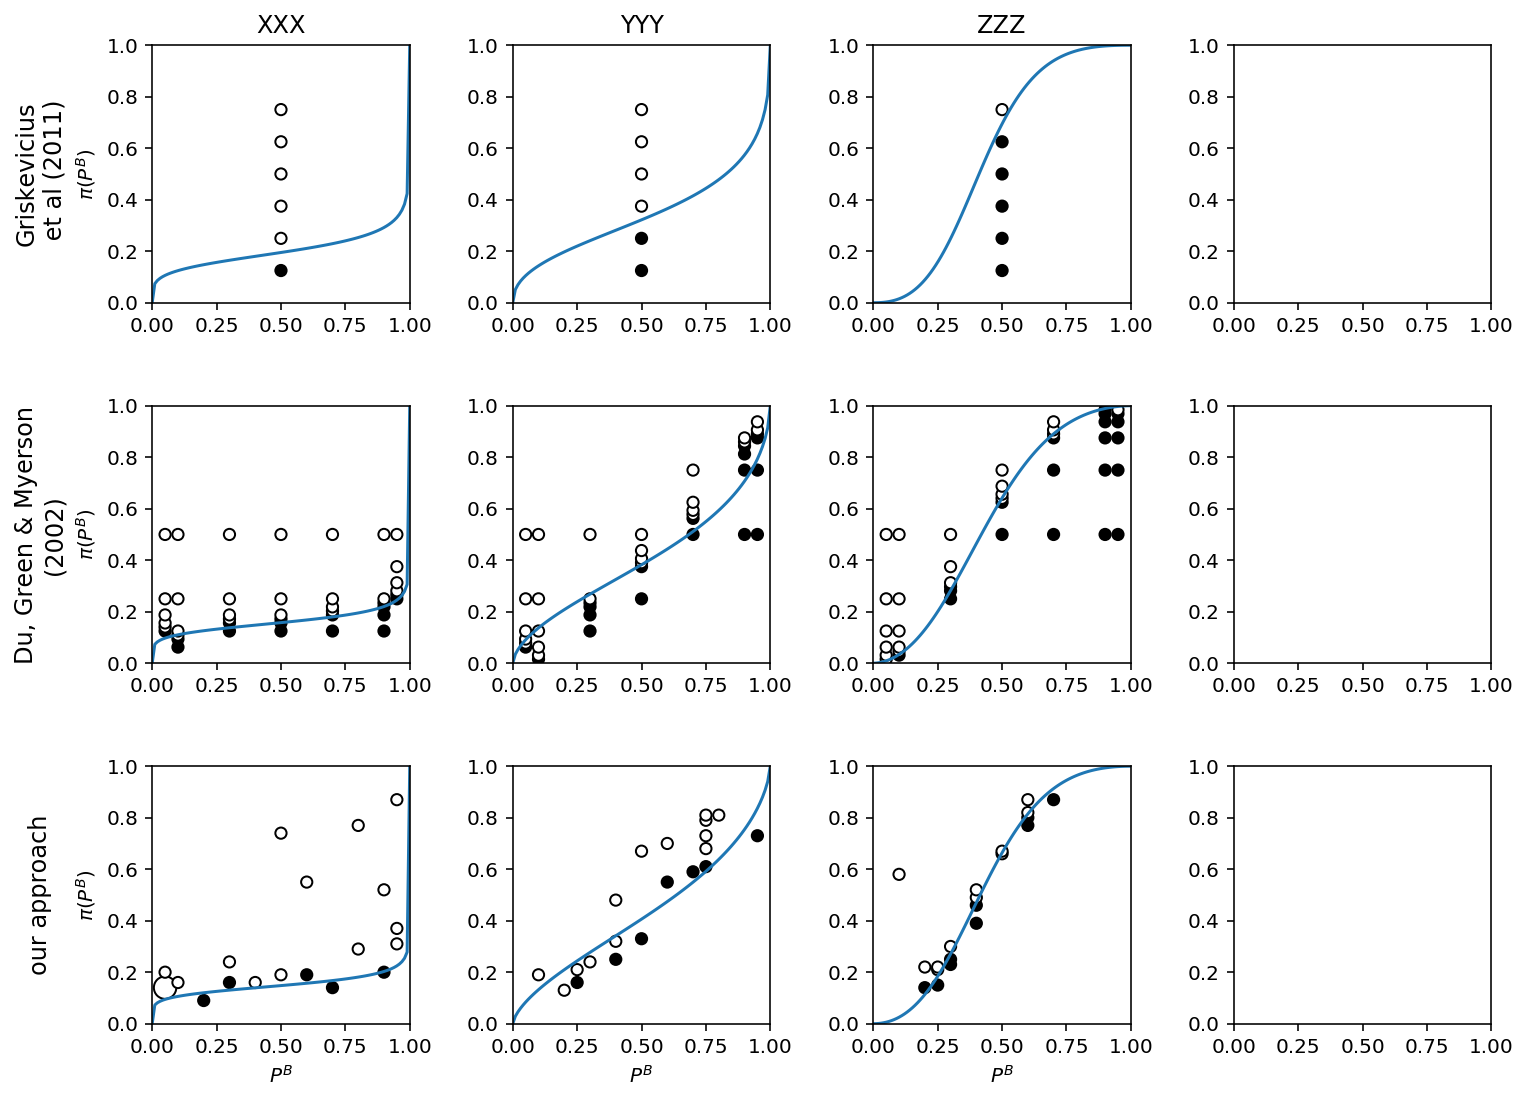

In [8]:
fig

## Code for parameter recovery sweeps
This will fill in the right hand column with parameter recovery sweeps for the corresponding experiment design approaches (rows). This gives a more high level overview of the resulting posterior over a wide range of $\log(k)$ values.

In [9]:
N = 7  # 70
θsweep = pd.DataFrame.from_dict({'logk': np.linspace(-8, -1, num=N), 
                                 'α': np.ones(N) * 2})

In [10]:
target_param_name = 'logk'

# Griskevicius -----------------------------------------------------------------
design_thing = Griskevicius2011()
model = data_generating_model(n_particles=5000)
θ_estimated_griskevicius, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_griskevicius = 7

# Koffarnus & Bickel ----------------------------------------------------------
design_thing = Koffarnus_Bickel()
model = data_generating_model(n_particles=5000)
θ_estimated_koffarnus, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_koffarnus = 5

# Du, Green & Myerson ----------------------------------------------------------
design_thing = DuGreenMyerson2002()
model = data_generating_model(n_particles=5000)
θ_estimated_DuGreenMyerson, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_DuGreenMyerson = 6*7

# DARC -----------------------------------------------------------------
max_trials = 20
D = DesignSpaceBuilder(PB=list(np.arange(0.01, 0.99, 20))).build()
design_thing = BayesianAdaptiveDesignGeneratorDARC(D, max_trials=max_trials)
model = data_generating_model(n_particles=5000)
θ_estimated_darc, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_darc = max_trials

starting parameter recovery sweep


KeyError: 'logk'

In [ ]:
def my_errorbar(ax, θsweep, θ_estimated):
    err_lower = θ_estimated['logk_median'] - θ_estimated['logk_lower95']
    err_upper = θ_estimated['logk_upper95'] - θ_estimated['logk_median']
        
    ax.plot([-8, -1], [-8, -1], c=[0.7, 0.7, 0.7])
    ax.errorbar(x=θsweep['logk'], 
                y=θ_estimated['logk_median'],
                yerr=[err_lower, err_upper],
                fmt='o',
                c='k', 
                ms=3)
    ax.set_xlabel(r'true $\log(k)$')
    ax.set_ylabel(r'estimated $\log(k)$')
    return

col = 3
ax[0,col].set_title('Parameter recovery\nsimulations')
# -----------------------------------------------------
my_errorbar(ax[0,col], θsweep, θ_estimated_kirby)
my_errorbar(ax[1,col], θsweep, θ_estimated_griskevicius)
my_errorbar(ax[2,col], θsweep, θ_estimated_koffarnus)
my_errorbar(ax[3,col], θsweep, θ_estimated_DuGreenMyerson)
my_errorbar(ax[4,col], θsweep, θ_estimated_frye)
my_errorbar(ax[5,col], θsweep, θ_estimated_darc)

# remove x-labels
[ax[i,col].set_xlabel('') for i in range(4)]

# move y axis to the right side
[ax[i,col].yaxis.tick_right() for i in range(5)]

# move y label to the right side
[ax[i,col].yaxis.set_label_position("right") for i in range(5)];

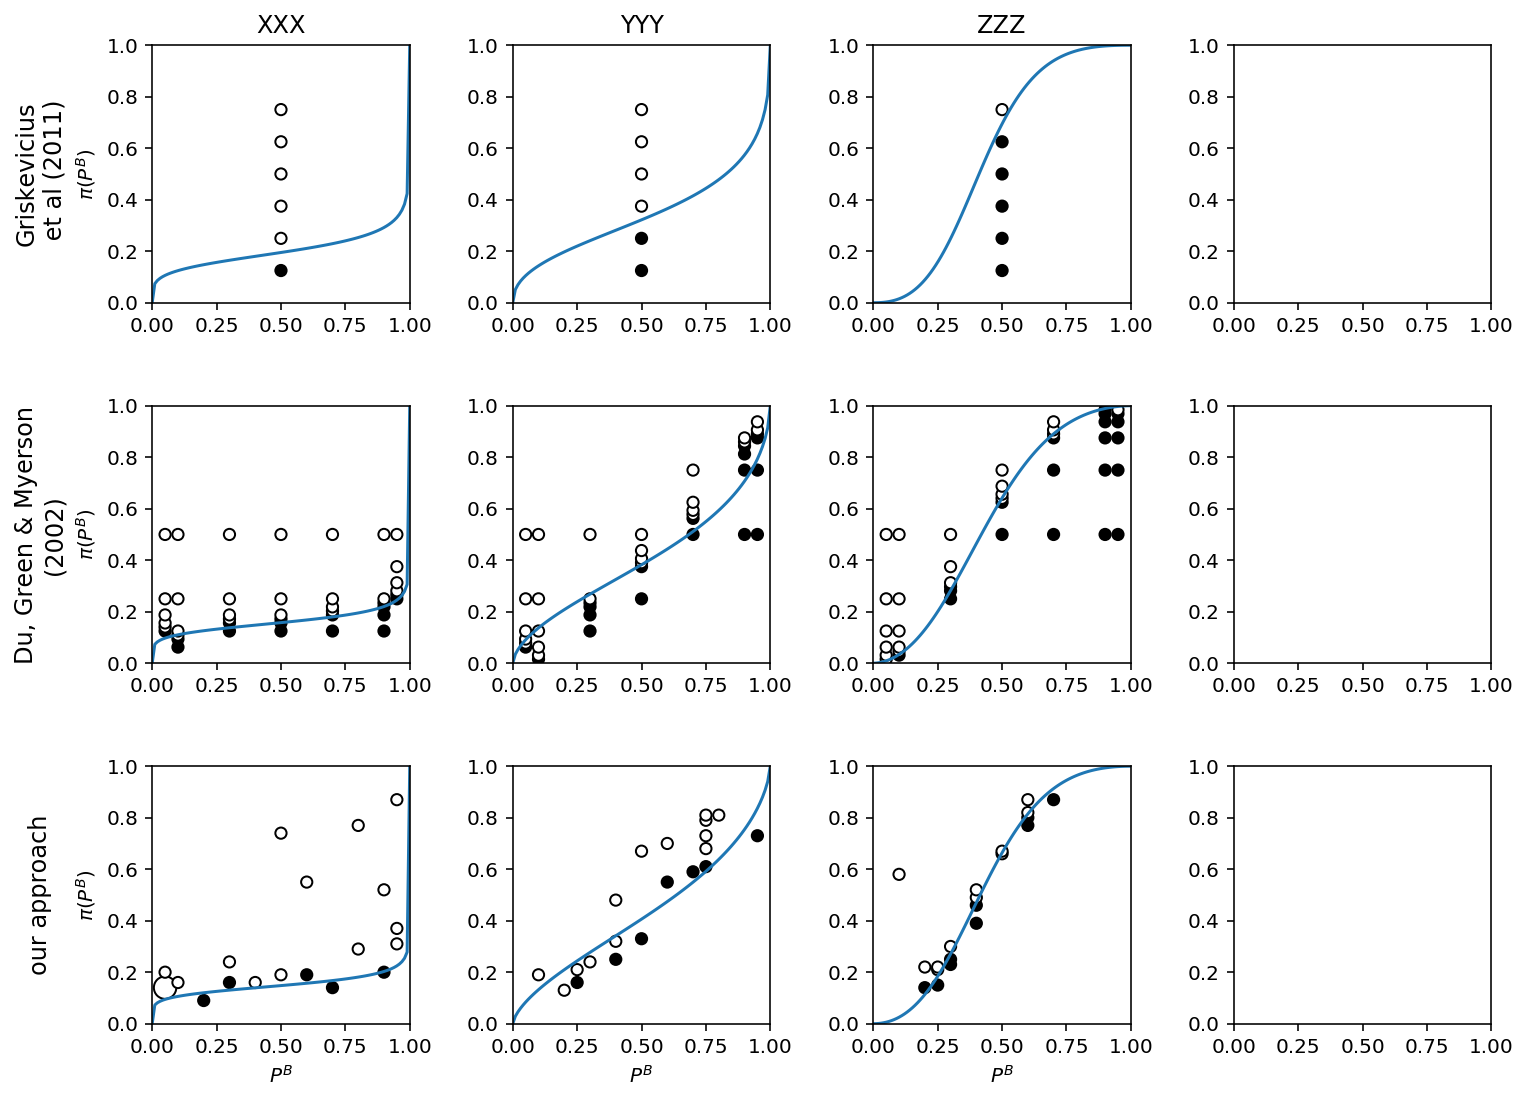

In [11]:
fig

In [ ]:
fig.savefig('risky_choice_demo.pdf', bbox_inches='tight')

In [ ]:
def w(p, δ, γ):
    return (δ*p**γ) / ( (δ*p**γ) + (1-p)**γ )

p = np.linspace(0,1,1000)

plt.plot(p, w(p, 0.5, 8))

In [ ]:
from scipy.stats import truncnorm

In [ ]:
myclip_a = 0 
myclip_b = 100
my_mean = 4
my_std = 3
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

r = truncnorm.rvs(a,b, loc=my_mean, scale=my_std, size=100000)
plt.hist(r, bins=50, density=True, histtype='stepfilled', alpha=0.2)